# Feature Engineering
## Configuration / Building Spark

In [1]:
from pyspark.sql import SparkSession, functions as F
import findspark

findspark.init("C:\Program Files\Spark\spark-3.3.1-bin-hadoop3")

spark = SparkSession.builder \
    .appName("House Price Model") \
    .master("local[4]") \
    .config("spark.sql.shuffle.partitions", "5") \
    .config("spark.sql.adaptive.enabled", True) \
    .getOrCreate()

## Load Data

In [2]:
path = "file:///Users/talha/OneDrive/Masaüstü/Talha Nebi Kumru/Data Science/Miuul/Machine Learning/Baseball_Salary_Prediction_with_ML/datasets/processed.parquet"
df = spark.read \
    .format("parquet") \
    .option("inferSchema", True) \
    .option("header", True) \
    .load(path)

In [3]:
df.limit(5).toPandas()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475,N
1,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480,A
2,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500,N
3,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91,N
4,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750,A


In [6]:
from _utils._eda_utils import *

In [7]:
numeric_columns, categoric_columns = seperate_columns(df.dtypes)

2023-04-18 05:48:06,496 - _utils.logging_utils - DEBUG - seperate_columns function executing...
2023-04-18 05:48:06,498 - _utils.logging_utils - INFO - 
Numerical Columns: ['Hits', 'Years', 'CWalks', 'Errors', 'CRBI', 'Salary', 'CRuns', 'Walks', 'CHits', 'Runs', 'CHmRun', 'Assists', 'CAtBat', 'AtBat', 'HmRun', 'PutOuts', 'RBI']
2023-04-18 05:48:06,500 - _utils.logging_utils - INFO - 
Categorical Columns: ['League', 'Division', 'NewLeague']


In [8]:
numeric_columns = [col for col in numeric_columns if col != 'Salary']

## Test Data

In [14]:
from _utils._sklearn_models import *
import warnings

warnings.simplefilter(action='ignore', category=Warning)

In [16]:
X, y = prepare_dataframe(df.toPandas(), 'Salary')

In [17]:
test_model = LinearRegressionSklearn(X, y)
test_model.init_model()

In [18]:
test_model.get_scores()

,0,1
5,neg_mean_squared_error,121132.085518
6,neg_root_mean_squared_error,342.132942
7,r2,0.343496


## Missing Values

In [19]:
from _utils._missing_utils import *

In [20]:
df = replace_null(df)

In [21]:
check_missing_values(df)

2023-04-18 05:52:55,539 - _utils.logging_utils - DEBUG - check_missing_values executing...


## Outliers
We checked the outliers. Data does not contains outliers but it is good to check **local outliers.**

In [22]:
from _utils._outliers_utils import *

In [23]:
local = LocalOutliers(df=df, numerical_cols=numeric_columns)

In [24]:
local.init_model()

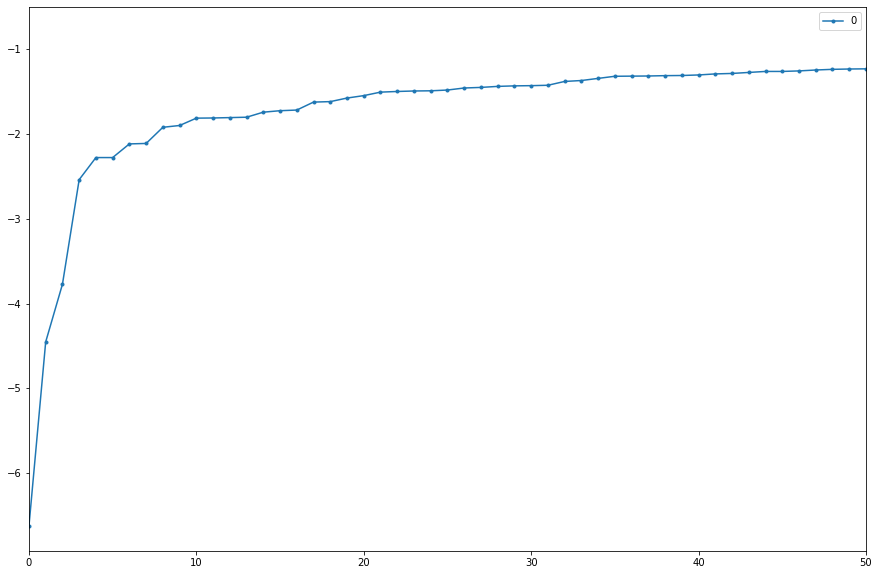

In [25]:
local.plot()

In [63]:
length = df.count()
for threshold in range(4, 15):
    local_outlier_df, non_local_outlier_df = local.get_local_outliers_df(threshold=threshold)
    
    X, y = prepare_df(non_local_outlier_df)

    test_model = LinearRegressionSklearn(X, y)
    test_model.init_model()
    
    print(f"%{len(local_outlier_df) / length * 100: .2f} data is removed from dataset.")
    print(f"{threshold} is selected for local outliers threshold. Model Evaluation:\n")
    print(test_model.get_scores(cv=5))

% 1.59 data is removed from dataset.
4 is selected for local outliers threshold. Model Evaluation:

                             0              1
5       neg_mean_squared_error  104619.008033
6  neg_root_mean_squared_error     320.981241
7                           r2       0.393416
% 1.59 data is removed from dataset.
5 is selected for local outliers threshold. Model Evaluation:

                             0              1
5       neg_mean_squared_error  104619.008033
6  neg_root_mean_squared_error     320.981241
7                           r2       0.393416
% 2.39 data is removed from dataset.
6 is selected for local outliers threshold. Model Evaluation:

                             0              1
5       neg_mean_squared_error  105742.257815
6  neg_root_mean_squared_error     323.215546
7                           r2       0.382285
% 2.79 data is removed from dataset.
7 is selected for local outliers threshold. Model Evaluation:

                             0              1
5 

In [64]:
local_outlier_df, non_local_outlier_df = local.get_local_outliers_df(threshold=13)

In [65]:
local_outlier_df

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
5,185,37,1,23,8,21,2,214,42,1,30,9,24,N,E,76,127,7,70,A
54,507,122,29,78,85,91,18,7761,1947,347,1175,1152,1380,A,E,808,108,2,535,A
117,151,41,4,26,21,19,2,288,68,9,45,39,35,A,W,28,56,2,95,A
118,278,86,4,33,38,45,1,278,86,4,33,38,45,N,W,102,4,2,110,N
129,591,157,16,90,78,26,4,2020,541,52,310,226,91,N,E,290,440,25,640,N
132,429,91,12,41,42,57,13,5590,1397,83,578,579,644,A,W,686,46,4,825,N
162,209,56,12,22,36,19,2,216,58,12,24,37,19,N,E,201,6,3,90,N
172,20,1,0,0,0,0,2,41,9,2,6,7,4,N,E,78,220,6,2127,N
188,237,52,0,15,25,30,24,14053,4256,160,2165,1314,1566,N,W,523,43,6,750,N
200,419,101,18,65,58,92,20,9528,2510,548,1509,1659,1342,A,W,0,0,0,487,A


In [66]:
df = spark.createDataFrame(non_local_outlier_df)

### Conclusion
<div class="alert alert-block alert-info"> <b>Final:</b> After handle local outliers, r2 increased <b>0.343496<b> to <b>0.443543<b> </div>

## Feature Extraction

In [67]:
def get_score(df):
    X, y = prepare_df(df)

    test_model = LinearRegressionSklearn(X, y)
    test_model.init_model()
    
    score = test_model.get_scores()
    
    return score[score[0] == 'r2'][1].values[0] # r2 score

In [68]:
def compare_score(first_score=None, second_score=None):
    return "Success" if max([first_score, second_score]) == second_score else "Failed"

In [69]:
first_score = get_score(df.toPandas())

In [70]:
first_score

0.44354308825392347

### Batting Average
This is the ratio of the number of hits to the number of at-bats. It could be a useful feature for predicting salary, as players with higher batting averages are generally considered to be better hitters.

In [71]:
temp_df = df.withColumn('BatAvg', F.col('Hits') / F.col('AtBat'))

In [72]:
compare_score(first_score, get_score(temp_df.toPandas()))

'Success'

In [73]:
df = temp_df

In [74]:
first_score = get_score(df.toPandas())

In [75]:
first_score

0.4492564382962566

### On-base Percentage
This is the ratio of the number of times a player reaches base (hits + walks + hit by pitch) to the number of plate appearances. It could be a useful feature for predicting salary, as players with higher on-base percentages are generally considered to be better at getting on base and creating scoring opportunities.

In [76]:
temp_df = df.withColumn('OBP', (F.col('Hits') + F.col('Walks')) / (F.col('AtBat') + F.col('Walks')))

In [77]:
compare_score(first_score, get_score(temp_df.toPandas()))

'Success'

In [78]:
df = temp_df

In [79]:
first_score = get_score(df.toPandas())

In [80]:
first_score

0.47021816948040795

### Slugging Percentage 
This is the total number of bases earned on hits divided by the number of at-bats. It could be a useful feature for predicting salary, as players with higher slugging percentages are generally considered to be more powerful hitters.

In [81]:
temp_df = df.withColumn('SLG', (F.col('Hits') + 2 * F.col('HmRun')) / F.col('AtBat'))

In [82]:
compare_score(first_score, get_score(temp_df.toPandas()))

'Failed'

### Plate Appearances
Plate appearances (PA) is a baseball statistic that represents the total number of times a batter has had the opportunity to bat during a game or a season.

In [83]:
temp_df = df.withColumn('PA', F.col('AtBat') + F.col('Walks'))

In [84]:
compare_score(first_score, get_score(temp_df.toPandas()))

'Success'

In [85]:
df = temp_df

In [86]:
first_score = get_score(df.toPandas())

In [87]:
first_score

0.4702181694804127

### Home Run Ratio
Home run ratio is a statistic used in baseball to measure a player's power hitting ability. It is calculated as the number of home runs hit by a player divided by the number of at-bats.

In [88]:
temp_df = df.withColumn('PA', F.col('HmRun') / F.col('AtBat'))

In [89]:
compare_score(first_score, get_score(temp_df.toPandas()))

'Failed'

### Fielding Percentage
Fielding percentage is a baseball statistic that measures a player's success rate in making defensive plays. Fielding percentage is a measure of a player's defensive ability and is often used in evaluating a player's overall performance.

In [90]:
temp_df = df.withColumn('PA', (F.col('PutOuts') + F.col('Assists')) / 
                        (F.col('PutOuts') + F.col('Assists') + F.col('Errors')))

In [91]:
compare_score(first_score, get_score(temp_df.toPandas().fillna(0)))

'Failed'

### Conclusion

In [92]:
get_score(df.toPandas())

0.4702181694804127

<div class="alert alert-block alert-info"> <b>Final:</b> With new features, r2 increased <b>0.443543<b> to <b>0.470218<b> </div>

## Model Selection

In [93]:
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split

In [94]:
X, y = prepare_df(df.toPandas())

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [95]:
reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None )

In [96]:
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

100%|██████████| 42/42 [00:02<00:00, 18.63it/s]


In [97]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
RandomForestRegressor,0.55,0.71,235.15,0.32
BaggingRegressor,0.53,0.70,240.08,0.04
ExtraTreesRegressor,0.51,0.69,244.55,0.17
AdaBoostRegressor,0.50,0.68,247.52,0.09
GradientBoostingRegressor,0.45,0.64,261.12,0.17
XGBRegressor,0.42,0.63,266.77,0.13
HistGradientBoostingRegressor,0.40,0.61,270.89,0.18
TransformedTargetRegressor,0.37,0.60,277.68,0.01
LinearRegression,0.37,0.60,277.68,0.01


## Random Forest Model

In [107]:
from _utils._sklearn_models import * 

In [108]:
model = RandomForestSklearn(X, y)

In [109]:
model.init_model(0)

In [111]:
model.get_scores()

,0,1
5,neg_mean_squared_error,74904.14
6,neg_root_mean_squared_error,267.19
7,r2,0.61


In [112]:
from sklearn.model_selection import GridSearchCV

In [113]:
model.model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [182]:
rf_params = {"max_depth": [None, 3, 5, 8, 10, 15],
             "max_features": [None, 3, 5, 7, "auto"],
             "min_samples_split": [2, 3, 4, 5, 8, 15, 20],
             "n_estimators": [50, 100, 150, 200, 300, 400, 700]}

In [183]:
grid_model = GridSearchCV(model.model, rf_params,
                          cv=5, n_jobs=-1, verbose=True).fit(X, y)

Fitting 5 folds for each of 1470 candidates, totalling 7350 fits


In [184]:
grid_model.best_params_

{'max_depth': 15,
 'max_features': 3,
 'min_samples_split': 5,
 'n_estimators': 200}

In [185]:
grid_model.best_score_

0.6663248083192558

In [114]:
rf_params = {
    'max_depth': 15,
    'max_features': 3,
    'min_samples_split': 5,
    'n_estimators': 200
}

In [115]:
model.model.set_params(**rf_params).fit(X, y)

RandomForestRegressor(max_depth=15, max_features=3, min_samples_split=5,
                      n_estimators=200)

In [116]:
model.get_scores()

,0,1
5,neg_mean_squared_error,73253.77
6,neg_root_mean_squared_error,262.47
7,r2,0.63


## Feature Importance

2023-04-18 06:09:55,866 - _utils.logging_utils - DEBUG - visualize_feature_importance function is executing...
2023-04-18 06:09:55,888 - _utils.logging_utils - INFO - Feature importances for the machine learning model:
    Value      Feature
0    4.59        AtBat
1    5.01         Hits
2    2.93        HmRun
3    3.30         Runs
4    4.31          RBI
5    5.17        Walks
6    3.90        Years
7    9.01       CAtBat
8    8.46        CHits
9    7.82       CHmRun
10   9.87        CRuns
11  10.85         CRBI
12   6.95       CWalks
13   2.73      PutOuts
14   1.07      Assists
15   1.29       Errors
16   2.23       BatAvg
17   4.33          OBP
18   5.44           PA
19   0.21     League_N
20   0.29   Division_W
21   0.26  NewLeague_N


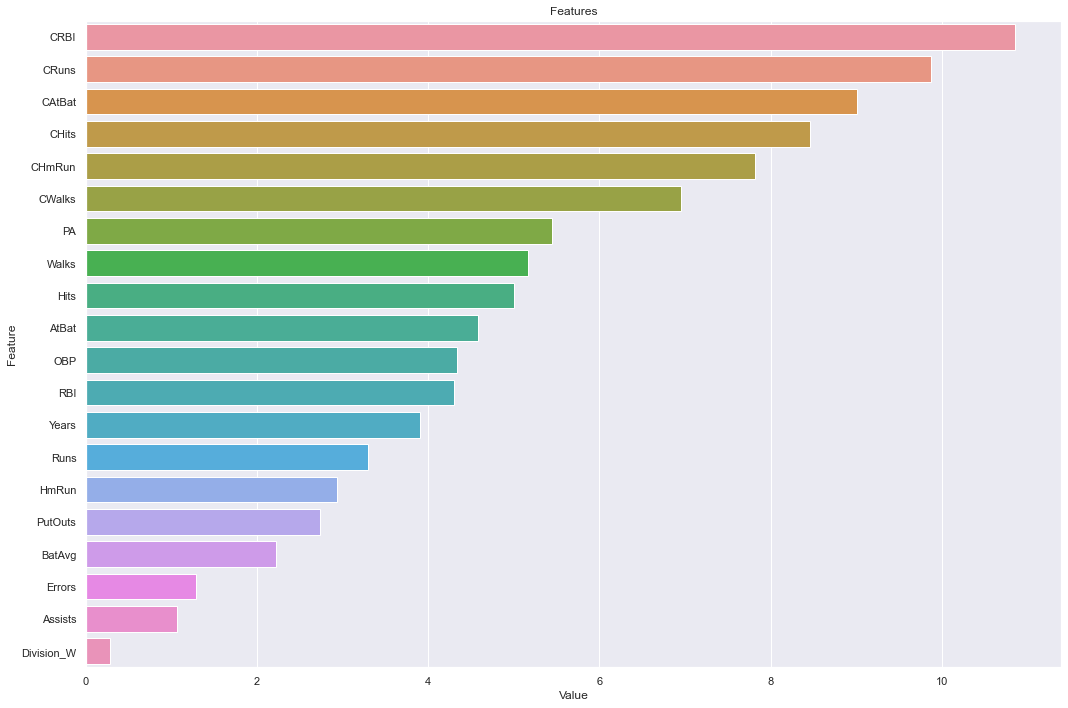

In [117]:
model.visualize_feature_importance()

In [118]:
spark.stop()

## Final
<div class="alert alert-block alert-info"> <b>Final:</b> With new features, r2 increased <b>0.47<b> to <b>0.63<b> </div>